In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
from Proj3_Utilies import sp_noise, gaussian_noise

In [2]:
outputPath = './data_processed/'
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

outputPath_1 = './data_processed/unet_label/'
if not os.path.exists(outputPath_1):
    os.makedirs(outputPath_1)

outputPath_2 = './data_processed/unet_data/'
if not os.path.exists(outputPath_2):
    os.makedirs(outputPath_2)
    
outputPath_3 = './data_processed/validation/'
if not os.path.exists(outputPath_3):
    os.makedirs(outputPath_3)

inputPath = "./CCPD2019/ccpd_base/" 
# inputPath = "./testimg/"
imgInfos = os.listdir(inputPath)

In [3]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂",
             "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]

alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']   

ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

In [11]:
pick = 5000
random.seed(1234)
picked = random.sample(imgInfos, pick)

# pick = 1000
# random.seed(2362)
# picked = random.sample(imgInfos, pick)

digi_all = []

for i in range(pick):
    print("Processing: ",i+1,"/",pick)
    clear_output(wait=True)
    
    cur = picked[i]
    
    ##################################
    # Plate Digits Label
    ##################################
    label_digi = re.split("-|&|_|\.",cur)[15:22]
    label_digi = np.array(label_digi,dtype=np.int)

    digi = []
    # digi.append(digi_dict[provinces[label_digi[0]]])
    # digi.append(digi_dict[alphabets[label_digi[1]]])
    # for j in range(2,7):
    #     digi.append(digi_dict[ads[label_digi[j]]])

    digi.append(provinces[label_digi[0]])
    digi.append(alphabets[label_digi[1]])
    for j in range(2,7):
        digi.append(ads[label_digi[j]])
    
    digi_all.append(digi)
    
    name = ''.join(digi)

    ##################################          
    # Plate Position Label
    ##################################
    img = cv2.imread(inputPath+cur)
    
    # Let two third of image to be noised
    # Half noised with sp, half with guassian
    if i%3 == 0:
        img = sp_noise(img,0.1)
    elif i%3 == 1:
        img = gaussian_noise(img,0,0.1)
    else:
        img = img

    pos_plate = re.split("-|&|_|\.",cur)[7:15]
    pos_plate = np.array(pos_plate,dtype = np.int).reshape(1,4,2)
    label_plate = np.zeros(img.shape[:2], dtype = "uint8")
    cv2.polylines(label_plate,pos_plate,1,255)
    cv2.fillPoly(label_plate,pos_plate,255)

    dsize = (512,512)
    
    img = cv2.resize(img,dsize)
    
    label_plate = cv2.resize(label_plate,dsize)
    ret,label_plate = cv2.threshold(label_plate,127,255,cv2.THRESH_BINARY)
#     label_plate = cv2.cvtColor(label_plate, cv2.COLOR_GRAY2BGR)

#     cv2.imwrite(outputPath_1+str(i)+".png",label_plate)
#     cv2.imwrite(outputPath_2+str(i)+".png",img)
    cv2.imencode('.png', label_plate)[1].tofile(outputPath_1+name+".png")
    cv2.imencode('.png', img)[1].tofile(outputPath_2+name+".png")
#     cv2.imencode('.png', img)[1].tofile(outputPath_3+name+".png")
    

df = pd.DataFrame(digi_all)
df.columns=["PRV","ALP","ADD_1","ADD_2","ADD_3","ADD_4","ADD_5"]
df.to_csv(outputPath+"cnn_label.csv")

print("Done!")

Done!


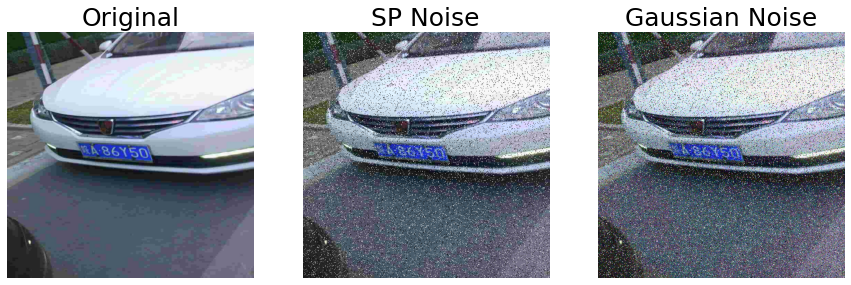

In [43]:
# check the performance of noise function
pick = random.sample(imgInfos,1)
img = cv2.imdecode(np.fromfile(inputPath+pick[0], dtype=np.uint8), cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(512,512))

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img)
ax1.set_title("Original",fontsize=25)
ax1.axis('off')

ax2 = fig.add_subplot(1,3,2)
ax2.set_title("SP Noise",fontsize=25)
ax2.imshow(sp_noise(img,0.1))
ax2.axis('off')

ax3 = fig.add_subplot(1,3,3)
ax3.set_title("Gaussian Noise",fontsize=25)
ax3.imshow(gaussian_noise(img,0,0.1))
ax3.axis('off')

plt.show()